# **🧬 Human Bone Marrow Single-Cell RNA-seq Analysis Pipeline**
This notebook executes a reproducible analysis pipeline for scRNA-seq data using Scanpy. The workflow process and analyze human bone marrow data through the following pipeline steps:

1. **Data Ingestion:** Loading raw count matrices.

2. **Quality Control (QC):** Filtering compromised cells (high mitochondrial content) and noise.

3. **Preprocessing:** Normalization, log-transformation, and feature selection (HVGs).

4. **Dimensionality Reduction:** PCA, Neighborhood Graph, and UMAP.

5. **Clustering:** Leiden community detection at multiple resolutions.

6. **Annotation:** Automated cell type scoring using Decoupler and biological validation using BioMart and PanglaoDB.

It provides a complete, reproducible record of the computational steps used to generate and interpret the final annotated cell populations.

In [1]:
# ==========================================
# 1. Environment Setup & Imports
# ==========================================
import os
import warnings

# Core Bioinformatics Libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress minor warnings for cleaner output
warnings.filterwarnings("ignore")

# Scanpy Settings for Reproducibility
sc.settings.verbosity = 3             # Print detailed processing info
sc.logging.print_header()
sc.settings.set_figure_params(
    dpi=100, 
    facecolor='white', 
    frameon=False, 
    vector_friendly=True, 
    fontsize=10
)

# ------------------------------------------
# AUTO-CREATE PROJECT DIRECTORIES
# ------------------------------------------
# The notebook is in "Stage_Two/notebooks".
# We use ".." to go up to "Stage_Two/" to find data and figures.
BASE_DIR = ".." 

DIRS = {
    "raw": os.path.join(BASE_DIR, "data", "raw"),
    "processed": os.path.join(BASE_DIR, "data", "processed"),
    "figures": os.path.join(BASE_DIR, "figures"),
}

# Create all folders if they don't exist
for key, path in DIRS.items():
    if not os.path.exists(path):
        print(f"📁 Creating folder: {path}")
        os.makedirs(path, exist_ok=True)
    else:
        print(f"✅ Folder exists: {path}")

# Set Scanpy to save figures in the main figures folder by default
sc.settings.figdir = DIRS["figures"]

print("\nSetup Complete. Directory structure is ready.")

✅ Folder exists: ..\data\raw
✅ Folder exists: ..\data\processed
✅ Folder exists: ..\figures

Setup Complete. Directory structure is ready.


### 🧩 **1. Data Loading & Inspection**

The human bone marrow single-cell expression matrix is loaded into an AnnData object.

* `adata.X`: Raw expression matrix (cells × genes).

* `adata.obs`: Metadata for each cell (e.g., disease stage).

* `adata.var`: Metadata for each gene (e.g., gene names).

**📥 Download Data:** If you haven't downloaded the data yet, please download `bone_marrow.h5ad` from this link and place it in `Stage_Two/data/raw/`:

[Download Raw Data (Google Drive)] (https://drive.google.com/file/d/14O01KspPMehZ1i4V6ZrwZIzHwoudz-nk/view?usp=drive_link)

In [2]:
# ==========================================
# 2. Data Loading
# ==========================================

# Define path to the raw file
RAW_DATA_PATH = os.path.join(DIRS["raw"], "bone_marrow.h5ad")

# Check if file exists before loading
if not os.path.exists(RAW_DATA_PATH):
    raise FileNotFoundError(
        f"❌ File not found at: {os.path.abspath(RAW_DATA_PATH)}\n"
        "Please download the file using the link above and move it to the 'data/raw' folder."
    )

# Load the dataset
print(f"loading data from {RAW_DATA_PATH}...")
adata = sc.read_h5ad(RAW_DATA_PATH)

# Enforce Unique Names
# Duplicate cell IDs can cause issues during clustering.
adata.var_names_make_unique()
adata.obs_names_make_unique()

# Inspect dimensions
print(f"✅ Dataset Loaded: {adata.n_obs} cells × {adata.n_vars} genes")

# View structure
display(adata.obs.head(3))
display(adata.var.head(3))

loading data from ..\data\raw\bone_marrow.h5ad...
✅ Dataset Loaded: 14783 cells × 17374 genes


,disease stage,treatment,timepoint,Dataset,sample,disease_original,disease_general,COVID-19 Condition,Lineage,Cell.group,...,is_primary_data,suspension_type,tissue_type,assay,disease,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
index,,,,,,,,,,,,,,,,,,,,,
Guo-AAACCTGAGAGCTTCT-2,severe,400 mg Tocilizumab at day 1,day 1,Guo et al._Nature Communication,Guo_P1-day1-rep2,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,severe,Myeloid,CD14+ Monocyte,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,39-year-old stage,2P)e%zgsv_
Guo-AAACCTGAGAGGTTGC-7,remission,400 mg Tocilizumab at day 1,day 7,Guo et al._Nature Communication,Guo_P2-day7,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD8+ T cell,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,78-year-old stage,Lv&N1yD6*0
Guo-AAACCTGAGATACACA-3,remission,400 mg Tocilizumab at day 1,day 5,Guo et al._Nature Communication,Guo_P1-day5-rep1,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD4+ T cell,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,39-year-old stage,DZ>`^5OH2o


,n_cells,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
ENSG00000161920,927,False,MED11,NCBITaxon:9606,gene,754,protein_coding
ENSG00000122335,429,False,SERAC1,NCBITaxon:9606,gene,2683,protein_coding
ENSG00000175548,149,False,ALG10B,NCBITaxon:9606,gene,1773,protein_coding


### 🧹 **2. Quality Control (QC)**
We filter out low-quality cells to ensure our analysis reflects biology, not technical noise.

**Key QC Metrics:**

1. **Mitochondrial (MT) Content:** High % indicates dying cells (cytoplasmic RNA leaks out, mitochondrial RNA remains).

2. **Ribosomal (RIBO) Content:** High % can indicate high metabolic activity or technical artifacts.

3. **Hemoglobin (HB):** Indicates Red Blood Cell (RBC) contamination (common in bone marrow).

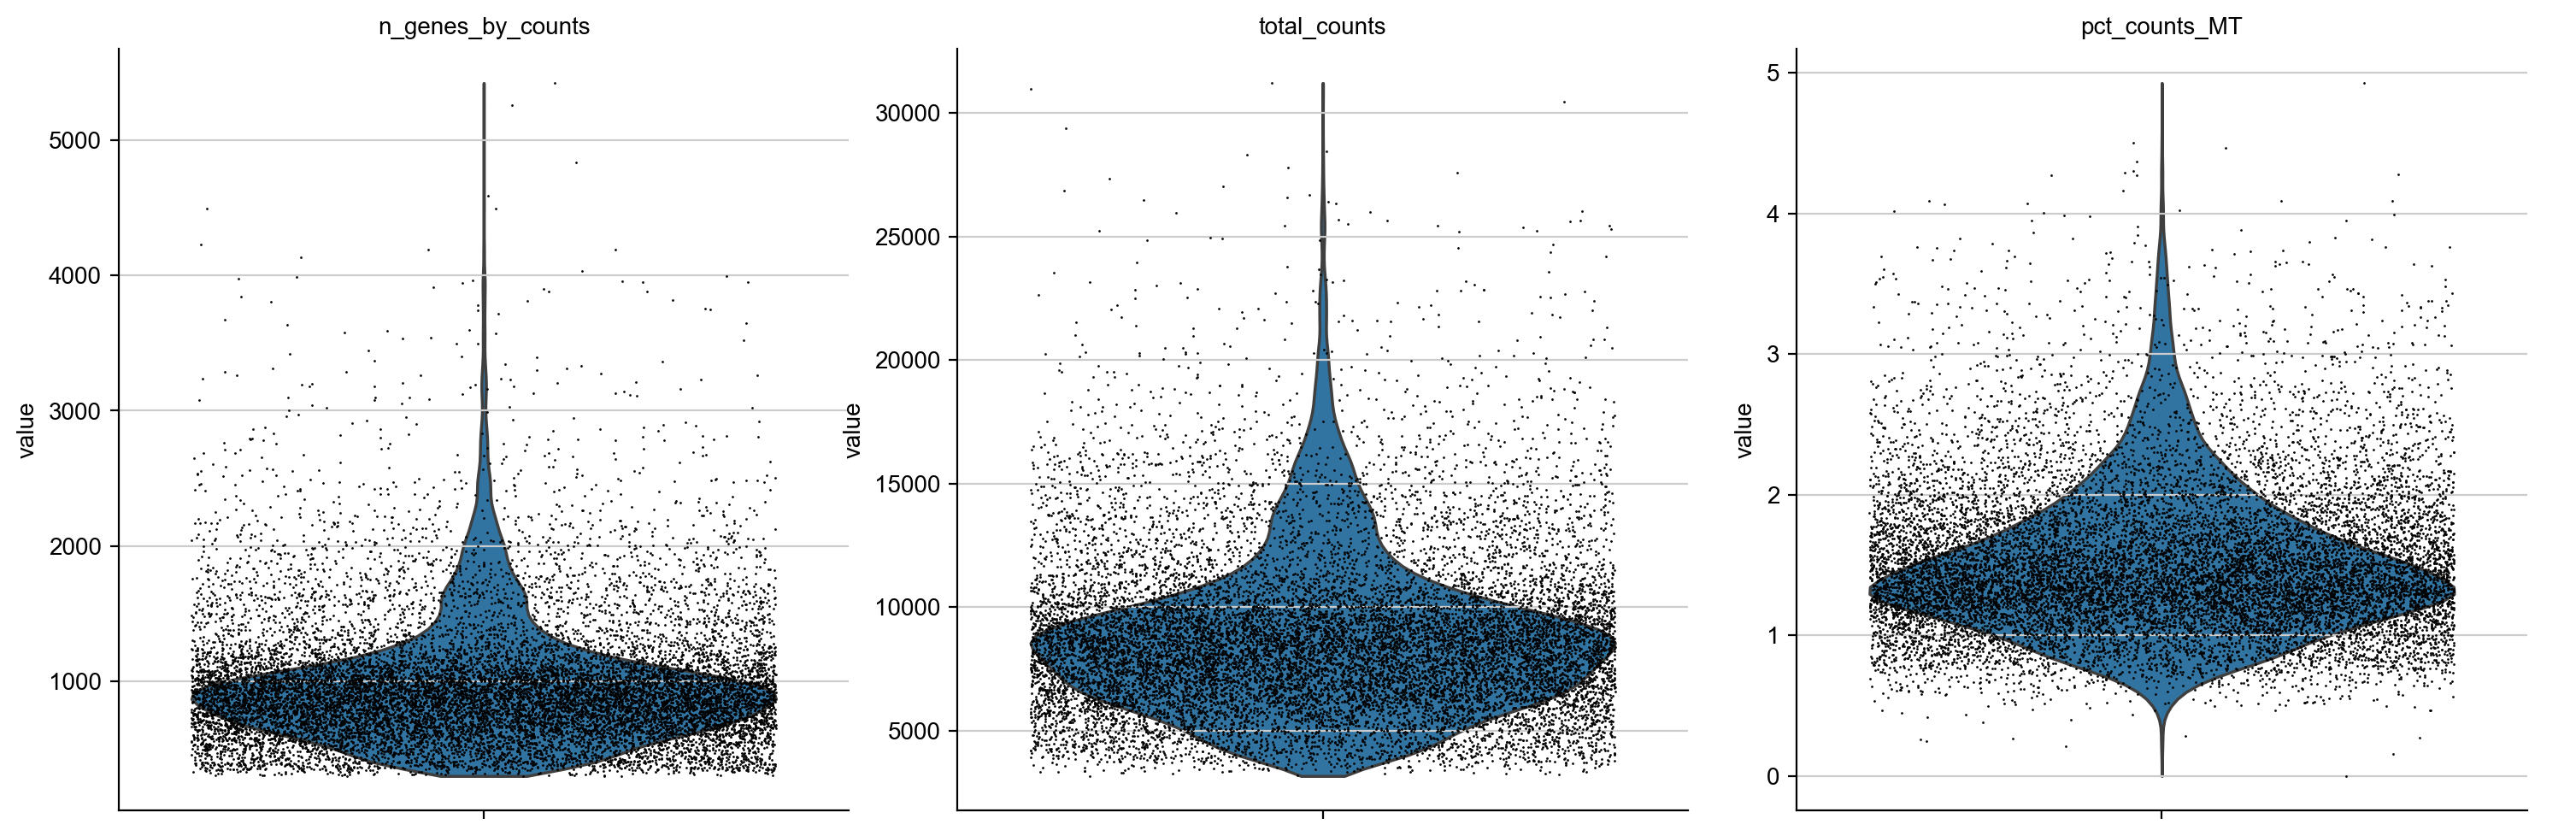

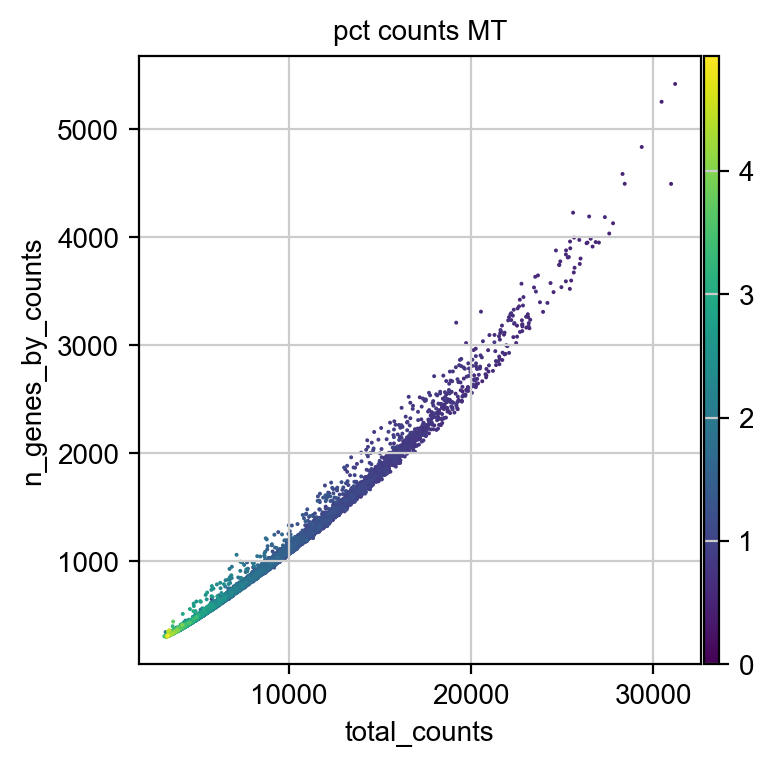

In [3]:
# ==========================================
# 3. Quality Control
# ==========================================

# 3.1 Tag Gene Groups
# We identify genes by their name prefixes
adata.var['MT'] = adata.var['feature_name'].str.upper().str.startswith('MT-')
adata.var['RIBO'] = adata.var['feature_name'].str.upper().str.startswith(('RPS', 'RPL'))
adata.var['HB'] = adata.var['feature_name'].str.upper().str.startswith(('HB', 'HBA', 'HBB'))

# 3.2 Calculate Metrics
# This adds 'n_genes_by_counts', 'total_counts', and 'pct_counts_MT' to adata.obs
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=['MT', 'RIBO', 'HB'], 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

# 3.3 Visualization (Violin Plots)
# Scanpy will save this as "figures/violin_QC_metrics.png"
sc.pl.violin(
    adata, 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'],
    jitter=0.4, 
    multi_panel=True,
    show=True,
    save="_QC_metrics.png" 
)

# 3.4 Scatter Plots
# Check for "stressed" cells: Low gene counts but High Mitochondrial %
sc.pl.scatter(
    adata, 
    x='total_counts', 
    y='n_genes_by_counts', 
    color='pct_counts_MT',
    show=True,
    save="_QC_scatter.png"
)

In [4]:
# ==========================================
# 4. Filtering
# ==========================================

print(f"Cells before filtering: {adata.n_obs}")

# 4.1 Filter Genes
# Remove genes seen in fewer than 3 cells (likely sequencing noise)
sc.pp.filter_genes(adata, min_cells=3)

# 4.2 Filter Cells (Low Quality)
# Remove cells with < 400 genes (empty droplets or poor libraries)
sc.pp.filter_cells(adata, min_genes=400)

# 4.3 Filter Cells (Stress/Death)
# Remove cells with > 5% mitochondrial reads. 
# 5% is a strict cutoff; standard is often 10-20%, but strict QC ensures high purity.
adata = adata[adata.obs['pct_counts_MT'] < 5, :]

print(f"Cells after filtering: {adata.n_obs}")

Cells before filtering: 14783
filtered out 2 genes that are detected in less than 3 cells
filtered out 568 cells that have less than 400 genes expressed
Cells after filtering: 14215


### 🧪 **3. Normalization & Feature Selection**
1. **Normalization:** Scales count data so that every cell has the same "library size" (median total counts), allowing us to compare gene expression between cells.

2. **Log Transformation:** Stabilizes variance (makes the data distribution more normal).

3. **Highly Variable Genes (HVGs):** We select the top 1,000 genes that vary the most across the dataset. These genes carry the biological signal (cell type differences).

normalizing counts per cell
    finished (0:00:01)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


<Axes: >

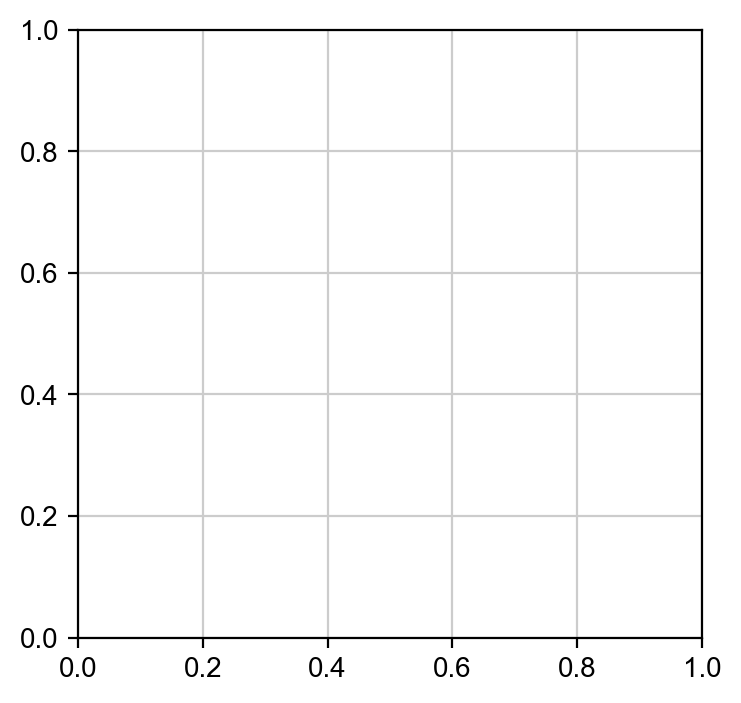

In [5]:
# ==========================================
# 5. Normalization & Log Transformation
# ==========================================

# Save raw counts in a layer for potential future use (e.g., DE analysis requiring integers)
adata.layers["counts"] = adata.X.copy()

# Normalize counts to median library size (scales all cells to have comparable total counts)
sc.pp.normalize_total(adata)

# Logarithmize data (X = log(X + 1))
# This stabilizes variance, making high-expressors comparable to low-expressors
sc.pp.log1p(adata)

# ==========================================
# 6. Feature Selection (HVGs)
# ==========================================

# Identify the top 1000 genes with the highest biological variance
# 'seurat' flavor works directly on the normalized/logged data (adata.X).
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=1000, 
    subset=False, 
    flavor="seurat"
)

# Plot the dispersion of genes
sc.pl.highly_variable_genes(adata, show=False, save="_dispersion.png")

### 🔍 **4. Dimensionality Reduction & Clustering**
We reduce the dimensionality of the data to visualize it and define cell communities.

1. **PCA:** Compresses 17,000 genes into ~30 principal components.

2. **Neighborhood Graph:** Connects cells with similar expression profiles.

3. **UMAP:** A 2D projection for visualization.

4. **Leiden Clustering:** Detects communities (clusters) in the graph.

computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:05:45)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:52)


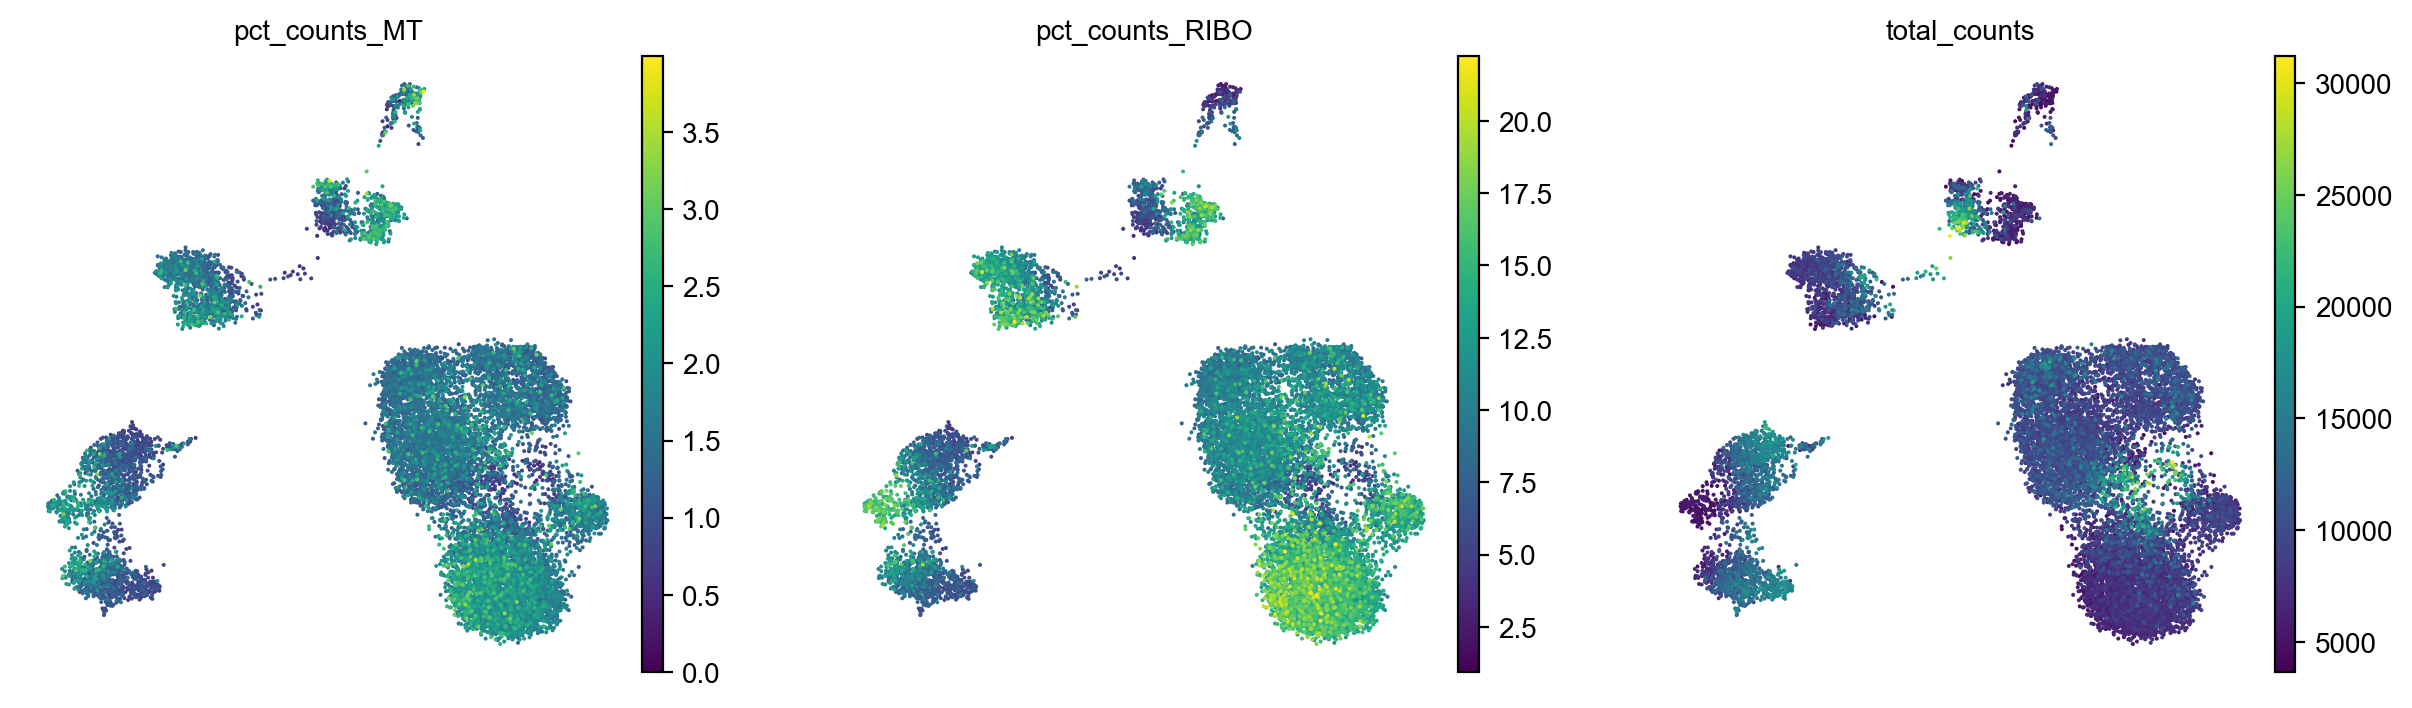

In [6]:
# ==========================================
# 7. PCA & Neighborhood Graph
# ==========================================

# Run PCA
sc.tl.pca(adata, svd_solver='arpack')

# Plot variance to confirm we captured the main signal
# Scanpy saves this as "figures/pca_variance_ratio_variance_ratio.png"
sc.pl.pca_variance_ratio(adata, n_pcs=30, log=False, show=False, save="_variance_ratio.png")

# Compute Neighbors (k-NN Graph)
# n_neighbors=10: defines how "local" the connections are
# n_pcs=40: uses top 40 PCs for distance calculation
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Compute UMAP
sc.tl.umap(adata)

# Check for technical artifacts on UMAP
# If cells cluster entirely by "total_counts", it suggests normalization issues.
sc.pl.umap(
    adata, 
    color=["pct_counts_MT", "pct_counts_RIBO", "total_counts"], 
    ncols=3,
    show=True,
    save="_QC_check.png"
)

In [7]:
# Install igraph for clustering
%pip install python-igraph leidenalg

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0_2', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0_5', the cluster labels (adata.obs, categorical) (0:00:04)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res1_0', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden_res2_0', the cluster labels (adata.obs, categorical) (0:00:03)


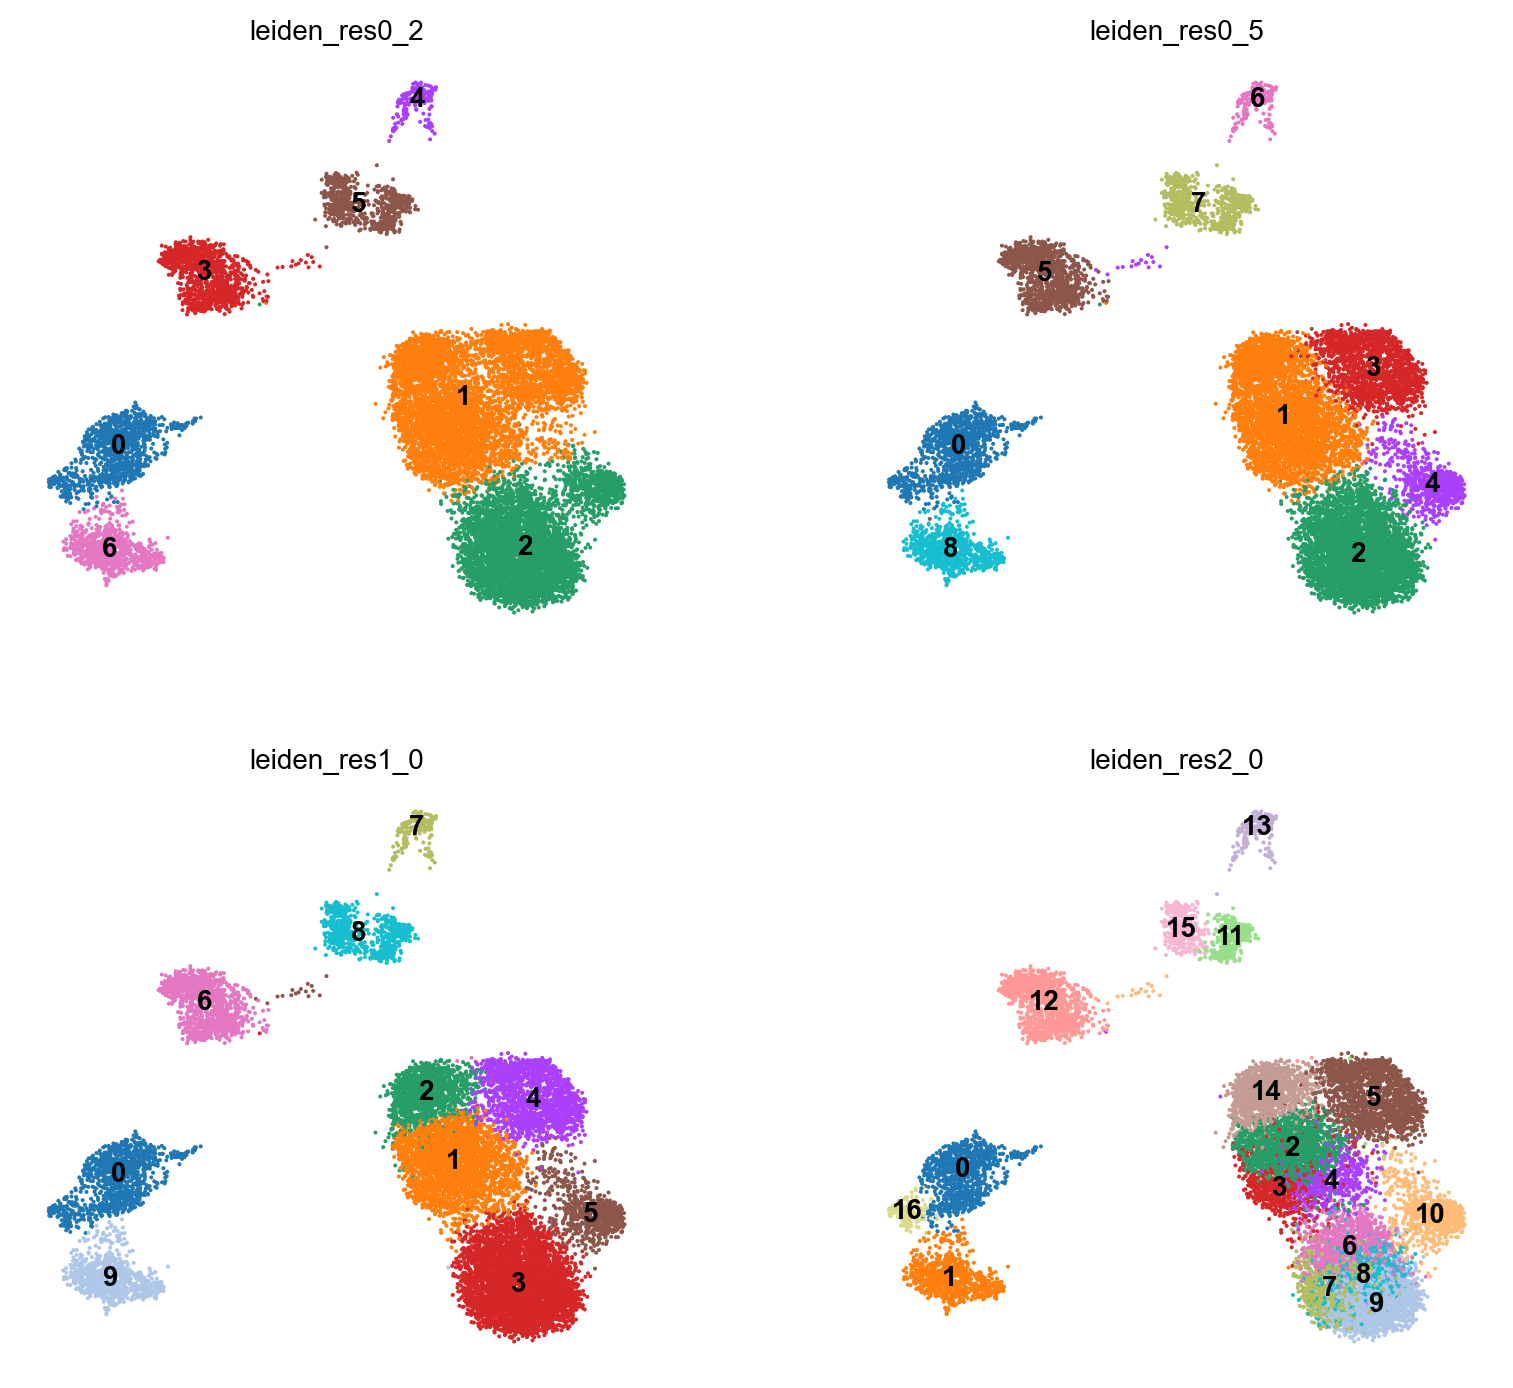

In [8]:
# ==========================================
# 9. Leiden Clustering
# ==========================================

# We run clustering at multiple resolutions.
# Low res (0.2) = Broad cell types (Myeloid vs Lymphoid)
# High res (2.0) = Subtypes (CD4+ Naive vs CD4+ Memory)
resolutions = [0.2, 0.5, 1.0, 2.0]

for res in resolutions:
    key_name = f"leiden_res{str(res).replace('.', '_')}"
    # We use flavor='igraph' for speed. 
    # If this fails despite installing igraph, try flavor='leidenalg' (slower)
    sc.tl.leiden(
        adata, 
        resolution=res, 
        key_added=key_name, 
        flavor="igraph", 
        n_iterations=2
    )

# Visualizing resolutions
sc.pl.umap(
    adata, 
    color=[f"leiden_res{str(res).replace('.', '_')}" for res in resolutions],
    legend_loc="on data",
    ncols=2,
    show=True,
    save="_Leiden_Resolutions.png"
)

### 🏷️ **5. Cell Type Annotation (Manual)**
In this step, we assign biological identities to the clusters identified by the Leiden algorithm.

Since automated tools can sometimes be incompatible with newer Python environments, we use the gold-standard approach: Manual Annotation based on Canonical Markers.

We examine the gene expression profiles of each cluster and map them to known cell types using established markers:

* **T Cells:** _CD3D, IL7R_

* **B Cells:** _MS4A1 (CD20), CD79A_

* **Monocytes:** _CD14, LYZ_

* **NK Cells:** _GNLY, NKG7_

* **Neutrophils:** _ELANE, MPO_

We will map these labels to our clusters (Resolution 1.0) and save the final annotated dataset.

In [10]:
# ==========================================
# 10. Cell Type Annotation (Manual Mapping)
# ==========================================
import os # Ensure os is imported just in case

# Dictionary mapping Cluster ID (from leiden_res1_0) -> Cell Type
cluster_annotations = {
    '0': 'Neutrophils',
    '1': 'Gamma delta T cells',
    '2': 'T memory cells',
    '3': 'NK cells',
    '4': 'B cells memory',
    '5': 'Platelets',
    '6': 'T memory cells',
    '7': 'Plasma cells',
    '8': 'Gamma delta T cells',
    '9': 'Monocytes'
}

print("✅ Applying the following annotations:")
print(cluster_annotations)

# Map the annotations to the 'leiden_res1_0' clustering resolution
adata.obs['cell_type'] = adata.obs['leiden_res1_0'].map(cluster_annotations)

# ==========================================
# 11. Save Annotated Data
# ==========================================

# Re-define the path locally to ensure this cell never fails
# logic: Go up one level (..) -> data -> processed -> file.h5ad
PROCESSED_DATA_PATH = os.path.join("..", "data", "processed", "bone_marrow_processed.h5ad")

# Ensure the folder exists
os.makedirs(os.path.dirname(PROCESSED_DATA_PATH), exist_ok=True)

print(f"💾 Saving processed data to: {os.path.abspath(PROCESSED_DATA_PATH)}")
adata.write_h5ad(PROCESSED_DATA_PATH)
print("✅ Save successful.")

✅ Applying the following annotations:
{'0': 'Neutrophils', '1': 'Gamma delta T cells', '2': 'T memory cells', '3': 'NK cells', '4': 'B cells memory', '5': 'Platelets', '6': 'T memory cells', '7': 'Plasma cells', '8': 'Gamma delta T cells', '9': 'Monocytes'}
💾 Saving processed data to: c:\Users\Opemidimeji\Desktop\HackBio_Internship_SC_RNA-Seq_2025\Stage_Two\data\processed\bone_marrow_processed.h5ad
✅ Save successful.


### 📊 **6. Visualization & Validation**
We visualize the expression of specific marker genes to validate our annotations.

1. **Dot Plot:** Shows the intensity and fraction of cells expressing specific markers across our new cell types.

2. **UMAP:** The final map of the bone marrow landscape, colored by biological identity.

Plotting 14 found markers...


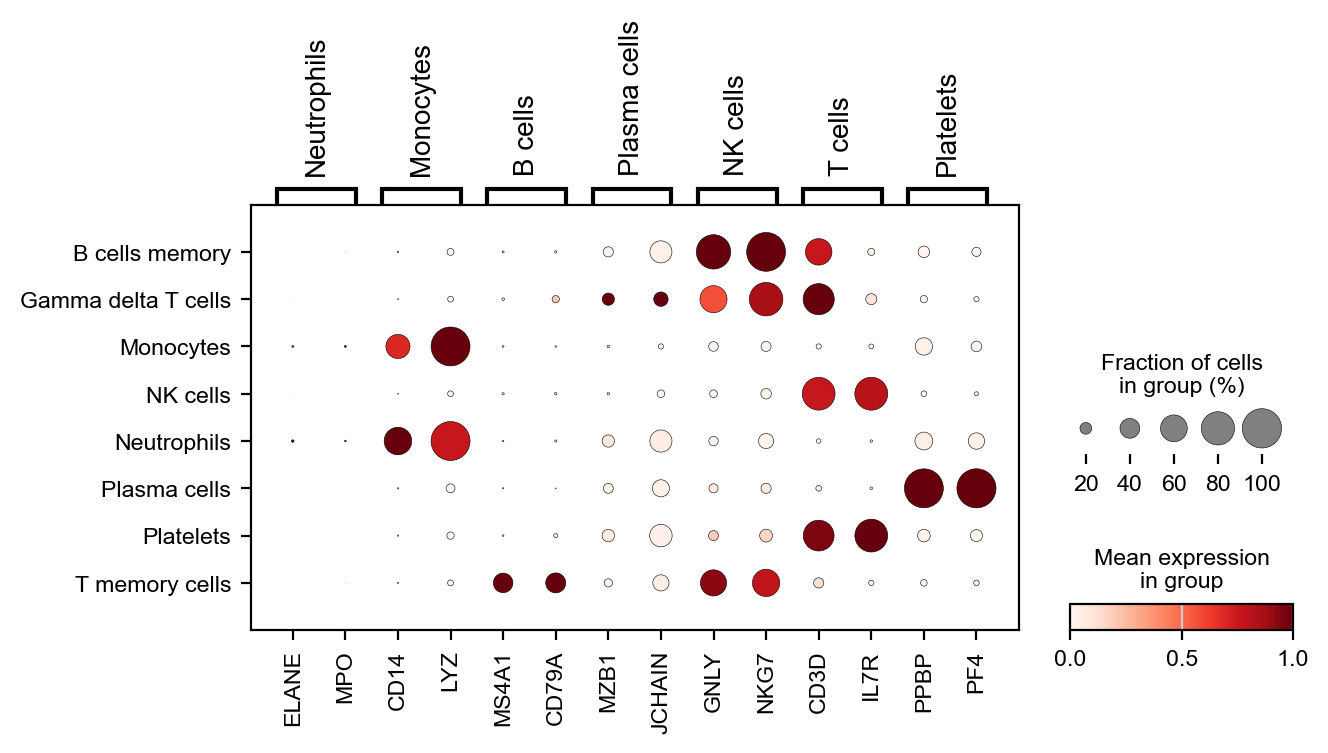

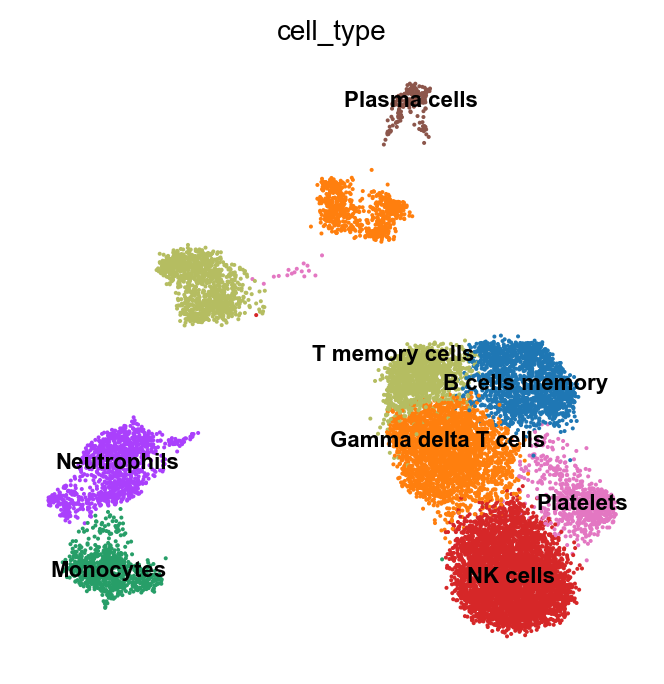

In [12]:
# ==========================================
# 12. Visualization of Marker Genes
# ==========================================

# 1. Define Canonical Markers (Gene Symbols)
marker_genes_dict = {
    "Neutrophils": ["ELANE", "MPO"],
    "Monocytes": ["CD14", "LYZ"],
    "B cells": ["MS4A1", "CD79A"],
    "Plasma cells": ["MZB1", "JCHAIN"],
    "NK cells": ["GNLY", "NKG7"],
    "T cells": ["CD3D", "IL7R"],
    "Platelets": ["PPBP", "PF4"]
}

# 2. VALIDATION FIX: Check against 'feature_name' column instead of Index
# We check if the symbols exist in the 'feature_name' column (where symbols are stored)
# instead of the index (which stores Ensembl IDs).
available_symbols = set(adata.var['feature_name'])

valid_markers = {
    k: [g for g in v if g in available_symbols] 
    for k, v in marker_genes_dict.items()
}

print(f"Plotting {sum(len(v) for v in valid_markers.values())} found markers...")

# 12.1 Dot Plot
# FIX: Added gene_symbols='feature_name'
# This tells Scanpy: "The genes in my list are Symbols, please look them up in the 'feature_name' column."
sc.pl.dotplot(
    adata, 
    valid_markers, 
    groupby="cell_type", 
    gene_symbols='feature_name',  # <--- CRITICAL FIX
    standard_scale='var',
    dendrogram=False,
    show=True,
    save="_Dotplot_CellType.png"
)

# 12.2 Final UMAP
sc.pl.umap(
    adata, 
    color="cell_type", 
    legend_loc="on data", 
    legend_fontsize=8, 
    show=True,
    save="_Final_Annotation_UMAP.png"
)